# Preprocessing of steady-states data

**Author:** M.G. Baltussen

**Estimated running time:** 20 minutes

**Generated output:**
```
plots/steadystate_traces_a.{svg,png}
plots/steadystate_traces_b.{svg,png}
data/steadystates.csv
```

In [1]:
""" System imports """
import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.75, 
rc={
    "axes.linewidth": 0.5,     
    'axes.facecolor':'#eceff4', 
    'axes.edgecolor':'#2e3440',
    'axes.labelcolor':'#2e3440',
    'text.color': '#2e3440',
    'xtick.color': '#2e3440',
    'ytick.color': '#2e3440',
    'font.family': 'Arial',
    'svg.fonttype': 'none',
    })
import colorcet as cc

nord_palette = [
    "#bf616a","#d08770","#ebcb8b","#a3be8c","#b48ead",
    "#8fbcbb","#88c0d0","#81a1c1","#5e81ac",
    "#2e3440","#3b4252","#434c5e","#4c566a",
    "#d8dee9","#e5e9f0","#eceff4",
]

sns.set_palette(nord_palette)

def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)

def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)


In [2]:
EXPERIMENTS = ['FTT008', 'FTT009', 'FTT010', 'FTT011', 'FTT012', 'FTT013', 'FTT014', 'FTT015', 'FTT016','FTT017']
flow_parameters = {
    exp: np.array([[c['length'], c['syringe_parameters']['NaOH']['reactor_concentration'], c['syringe_parameters']['formaldehyde']['reactor_concentration']] 
                    for c in toml.load(f"../data/steadystates/{exp}_flow_parameters.toml")['sections']
                ]) for exp in EXPERIMENTS
}

In [6]:
def preprocess(name: str, inputs, fig, axes, OFFSET: int, SS_TIME: int = 600, frac=1):
    """ For the specified experiment, 
    plot the inputs and corresponding ion traces on the specified axes
    with steady-state regions indicated.
    Returns the steadystate data as a DataFrame together with inputs """
    
    # Align inputs with ion signals
    df_inputs = pd.DataFrame(
        inputs, columns=['time', 'NaOH', 'Form']
    ).assign(time = np.cumsum(inputs[:,0])  + OFFSET)

    # Concatenate ion signals into 1 DataFrame, 
    # round retention time to 1 decimal to standardize time indices
    # and pivot to wide format (species as columns)
    files = pathlib.Path(f"../data/steadystates/{name}/").glob('*.dat')
    df = pd.concat((pd.read_csv(f, sep='\t').assign(species=f.stem) for f in files), ignore_index=True)
    df = df.assign(retention_time = df.retention_time.round(1))
    df = df.pivot(index=['retention_time'], columns='species', values='intensity')

    pad_frac = np.array([-0.05, 0.05])
    ranges = np.array([[10, 50], [10, 150]])
    pad = pad_frac*np.diff(ranges, axis=1)
    extends = ranges + pad
    x_extend = extends[0]
    y_extend = extends[1]
    axes[0].set_xlim(*x_extend)
    axes[0].set_ylim(*y_extend)
    axes[0].set_xlabel(r"[NaOH] (mM)")
    axes[0].set_ylabel(r"[Form.] (mM)")

    # Plot experiment ipnuts on first axis and add colorbar to indicate order
    sns.scatterplot(ax=axes[0], data=df_inputs, x='NaOH', y='Form', hue='time', 
                legend=None, palette='flare')
    fig.colorbar(ax=axes[0], mappable=ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), 
                                                     norm=Normalize(vmin=df_inputs.time.min(), vmax=df_inputs.time.max())), 
            orientation='vertical', location='right', shrink=1,
            ticks=df_inputs.time[::2].round(-1),
            label='Time (s)'
    )

    sns.scatterplot(data=df.sample(frac=frac), legend=None, s=0.2,
                    alpha=0.1, 
                    palette=cc.glasbey_dark[:df.shape[1]], lw=0,
                    rasterized=True, ax=axes[1])
    axes[1].vlines(df_inputs.time, 0, 0.12, lw=0.2)
    axes[1].vlines(df_inputs.time - SS_TIME, 0, 0.12, lw=0.2)
    axes[1].set_ylabel("Signal (A.U.)")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_xlim(0, 26000)

    FTT_ss = [] 
    for idx, input in df_inputs.iterrows():
        start = input.time - SS_TIME
        end = input.time
        data = df.query(f"{start} < retention_time < {end}")
        FTT_ss.append(data.mean())
        
    FTT_ss = pd.concat(FTT_ss, axis=1).transpose()
    return df_inputs.join(FTT_ss).assign(exp=name)

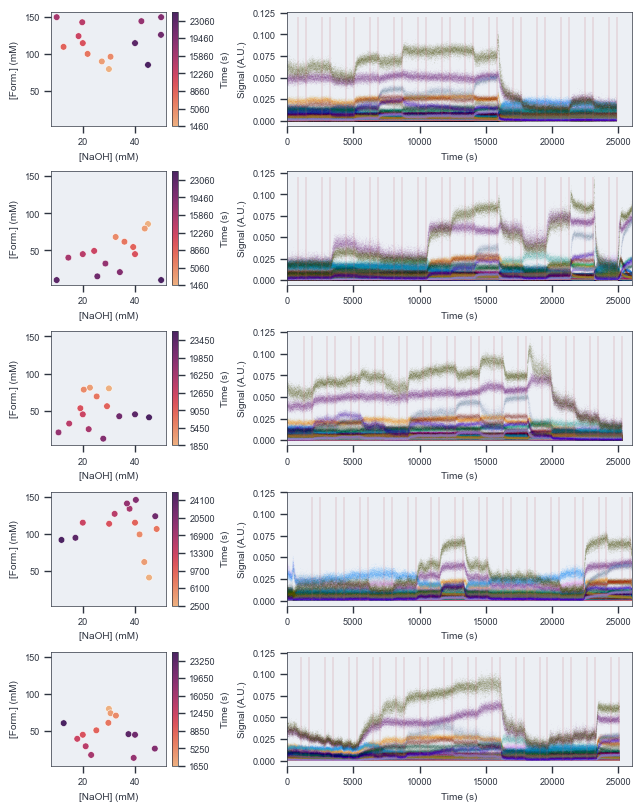

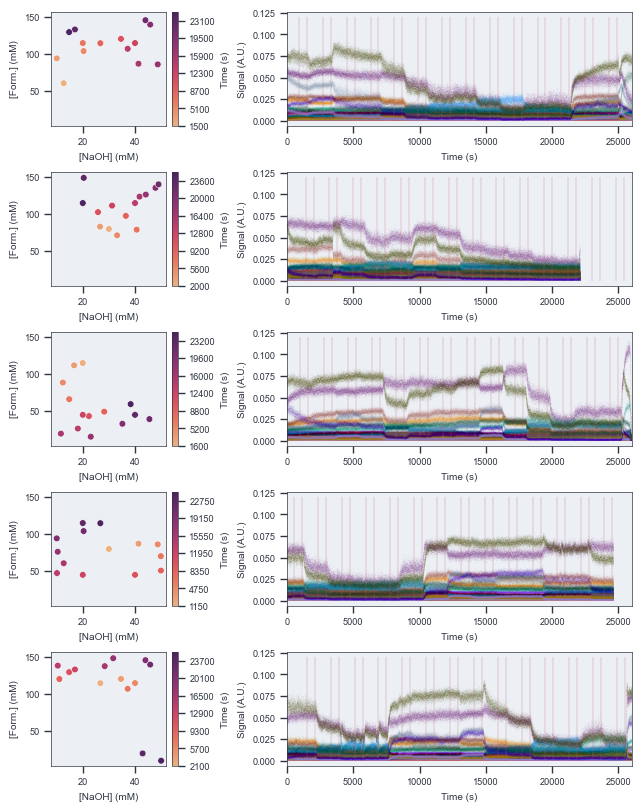

In [7]:
fig, axes = plt.subplots(5,2, figsize=(6.3, 8), gridspec_kw={'width_ratios': [1,3]}, constrained_layout=True)

OFFSETS = {
    "FTT008": 260,
    "FTT009": 260,
    "FTT010": -1750,
    "FTT011": -1100,
    "FTT012": -1950,
    "FTT013": -2100,
    "FTT014": -1600,
    "FTT015": -2000,
    "FTT016": -2450,
    "FTT017": -1500,
}
df_all = []
for i, exp in enumerate(EXPERIMENTS[:5]):
    df_all.append(preprocess(exp, flow_parameters[exp], fig, axes[i], OFFSETS[exp]))

save_si(f"steadystate_traces_a")


fig, axes = plt.subplots(5,2, figsize=(6.3, 8), gridspec_kw={'width_ratios': [1,3]}, constrained_layout=True)

for i, exp in enumerate(EXPERIMENTS[5:]):
    df_all.append(preprocess(exp, flow_parameters[exp], fig, axes[i], OFFSETS[exp]))

save_si(f"steadystate_traces_b")



In [5]:
""" Remove selected failed steady-states (flow errors) and save processed data"""
df_all = pd.concat(df_all).reset_index(drop=True).drop(
    [0, 27, 28, 56, 84, 112]).dropna() 
df_all.to_csv("../data/steadystates.csv", index=True)
df_all

,time,NaOH,Form,C10+H2O_Ca_2p_I1,C10+H2O_Ca_2p_I2,C10+H2O_Ca_2p_I3,C10_Ca_2p_I1,C10_Ca_2p_I2,C10_Ca_2p_I3,C10_Ca_2p_I4,...,C9-O2_Ca_2p_I4,C9-O_Ca_2p_I1,C9-O_Ca_2p_I2,C9-O_Ca_2p_I3,C9-O_Ca_2p_I4,C9_Ca_2p_I1,C9_Ca_2p_I2,C9_Ca_2p_I3,C9_Ca_2p_I4,exp
1,3260.0,27.2896,90.2669,0.004688,0.006608,0.000261,0.005009,0.024014,0.000248,0.000506,...,0.000211,0.000346,0.001681,0.005278,0.000299,0.002147,0.012317,0.062326,0.010031,FTT008
2,5060.0,30.6315,96.6331,0.004755,0.005385,0.000320,0.005124,0.020682,0.000283,0.000617,...,0.000258,0.000407,0.001698,0.005388,0.000384,0.001705,0.008822,0.050782,0.007037,FTT008
3,6860.0,21.8414,100.4384,0.004011,0.007913,0.000197,0.004291,0.025851,0.000195,0.000316,...,0.000173,0.000307,0.002028,0.005151,0.000241,0.003283,0.020522,0.072326,0.015602,FTT008
4,8660.0,12.6292,109.9410,0.002072,0.007689,0.000125,0.003511,0.022602,0.000154,0.000189,...,0.000111,0.000225,0.002092,0.003368,0.000153,0.007551,0.036703,0.069206,0.023238,FTT008
5,10460.0,20.0000,115.0000,0.003669,0.008127,0.000167,0.004635,0.027377,0.000188,0.000281,...,0.000144,0.000279,0.002081,0.004430,0.000217,0.004870,0.029162,0.080224,0.017172,FTT008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,18300.0,31.6440,148.5580,0.004468,0.004894,0.000326,0.004695,0.018131,0.000268,0.000719,...,0.000253,0.000348,0.001677,0.004860,0.000384,0.001217,0.007060,0.044717,0.007107,FTT017
136,20100.0,43.9860,145.8833,0.003626,0.002366,0.000436,0.004661,0.009885,0.000381,0.000605,...,0.000355,0.000452,0.001942,0.004846,0.000477,0.000960,0.004347,0.022788,0.002879,FTT017
137,21900.0,45.8087,139.9426,0.003180,0.002060,0.000432,0.004304,0.008824,0.000397,0.000607,...,0.000373,0.000478,0.001987,0.004902,0.000509,0.000877,0.003848,0.019744,0.002698,FTT017
138,23700.0,42.9120,19.8840,0.003408,0.001480,0.000548,0.003835,0.009940,0.000441,0.000698,...,0.000420,0.000562,0.001545,0.005760,0.000572,0.001024,0.003941,0.028608,0.003248,FTT017
